In [11]:
import cv2
from tqdm import tqdm
from glob import glob
import numpy as np
import random

import xml.etree.ElementTree as ET

from IPython.display import *
width, height, target_width = 2560, 1920, 299
def show(img):
    cv2.imwrite('test.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 50])
    display(Image('test.jpg'))

In [12]:
def check_union(x1, y1, x2, y2, bboxs, target_width=299):
    unions = []
    value = 0.0
    for x12, y12, x22, y22 in bboxs:
        minx = max(x1, x12)
        miny = max(y1, y12)
        maxx = min(x2, x22)
        maxy = min(y2, y22)
        union = (minx < maxx) & (miny < maxy)
        v = (maxx - minx) * (maxy - miny) / (target_width ** 2)
        if union:
            value += v
        unions.append(union)
    return np.any(unions), value

In [13]:
fnames = set(glob('xuelang_round1_train_part2_20180705/*/*.jpg'))
fnames -= set(glob('xuelang_round1_train_part2_20180705/正常/*.jpg'))
fnames = list(fnames)
img_fname = random.choice(fnames)
img_fname

'xuelang_round1_train_part2_20180705/愣断/J01_2018.06.25 13_48_32.jpg'

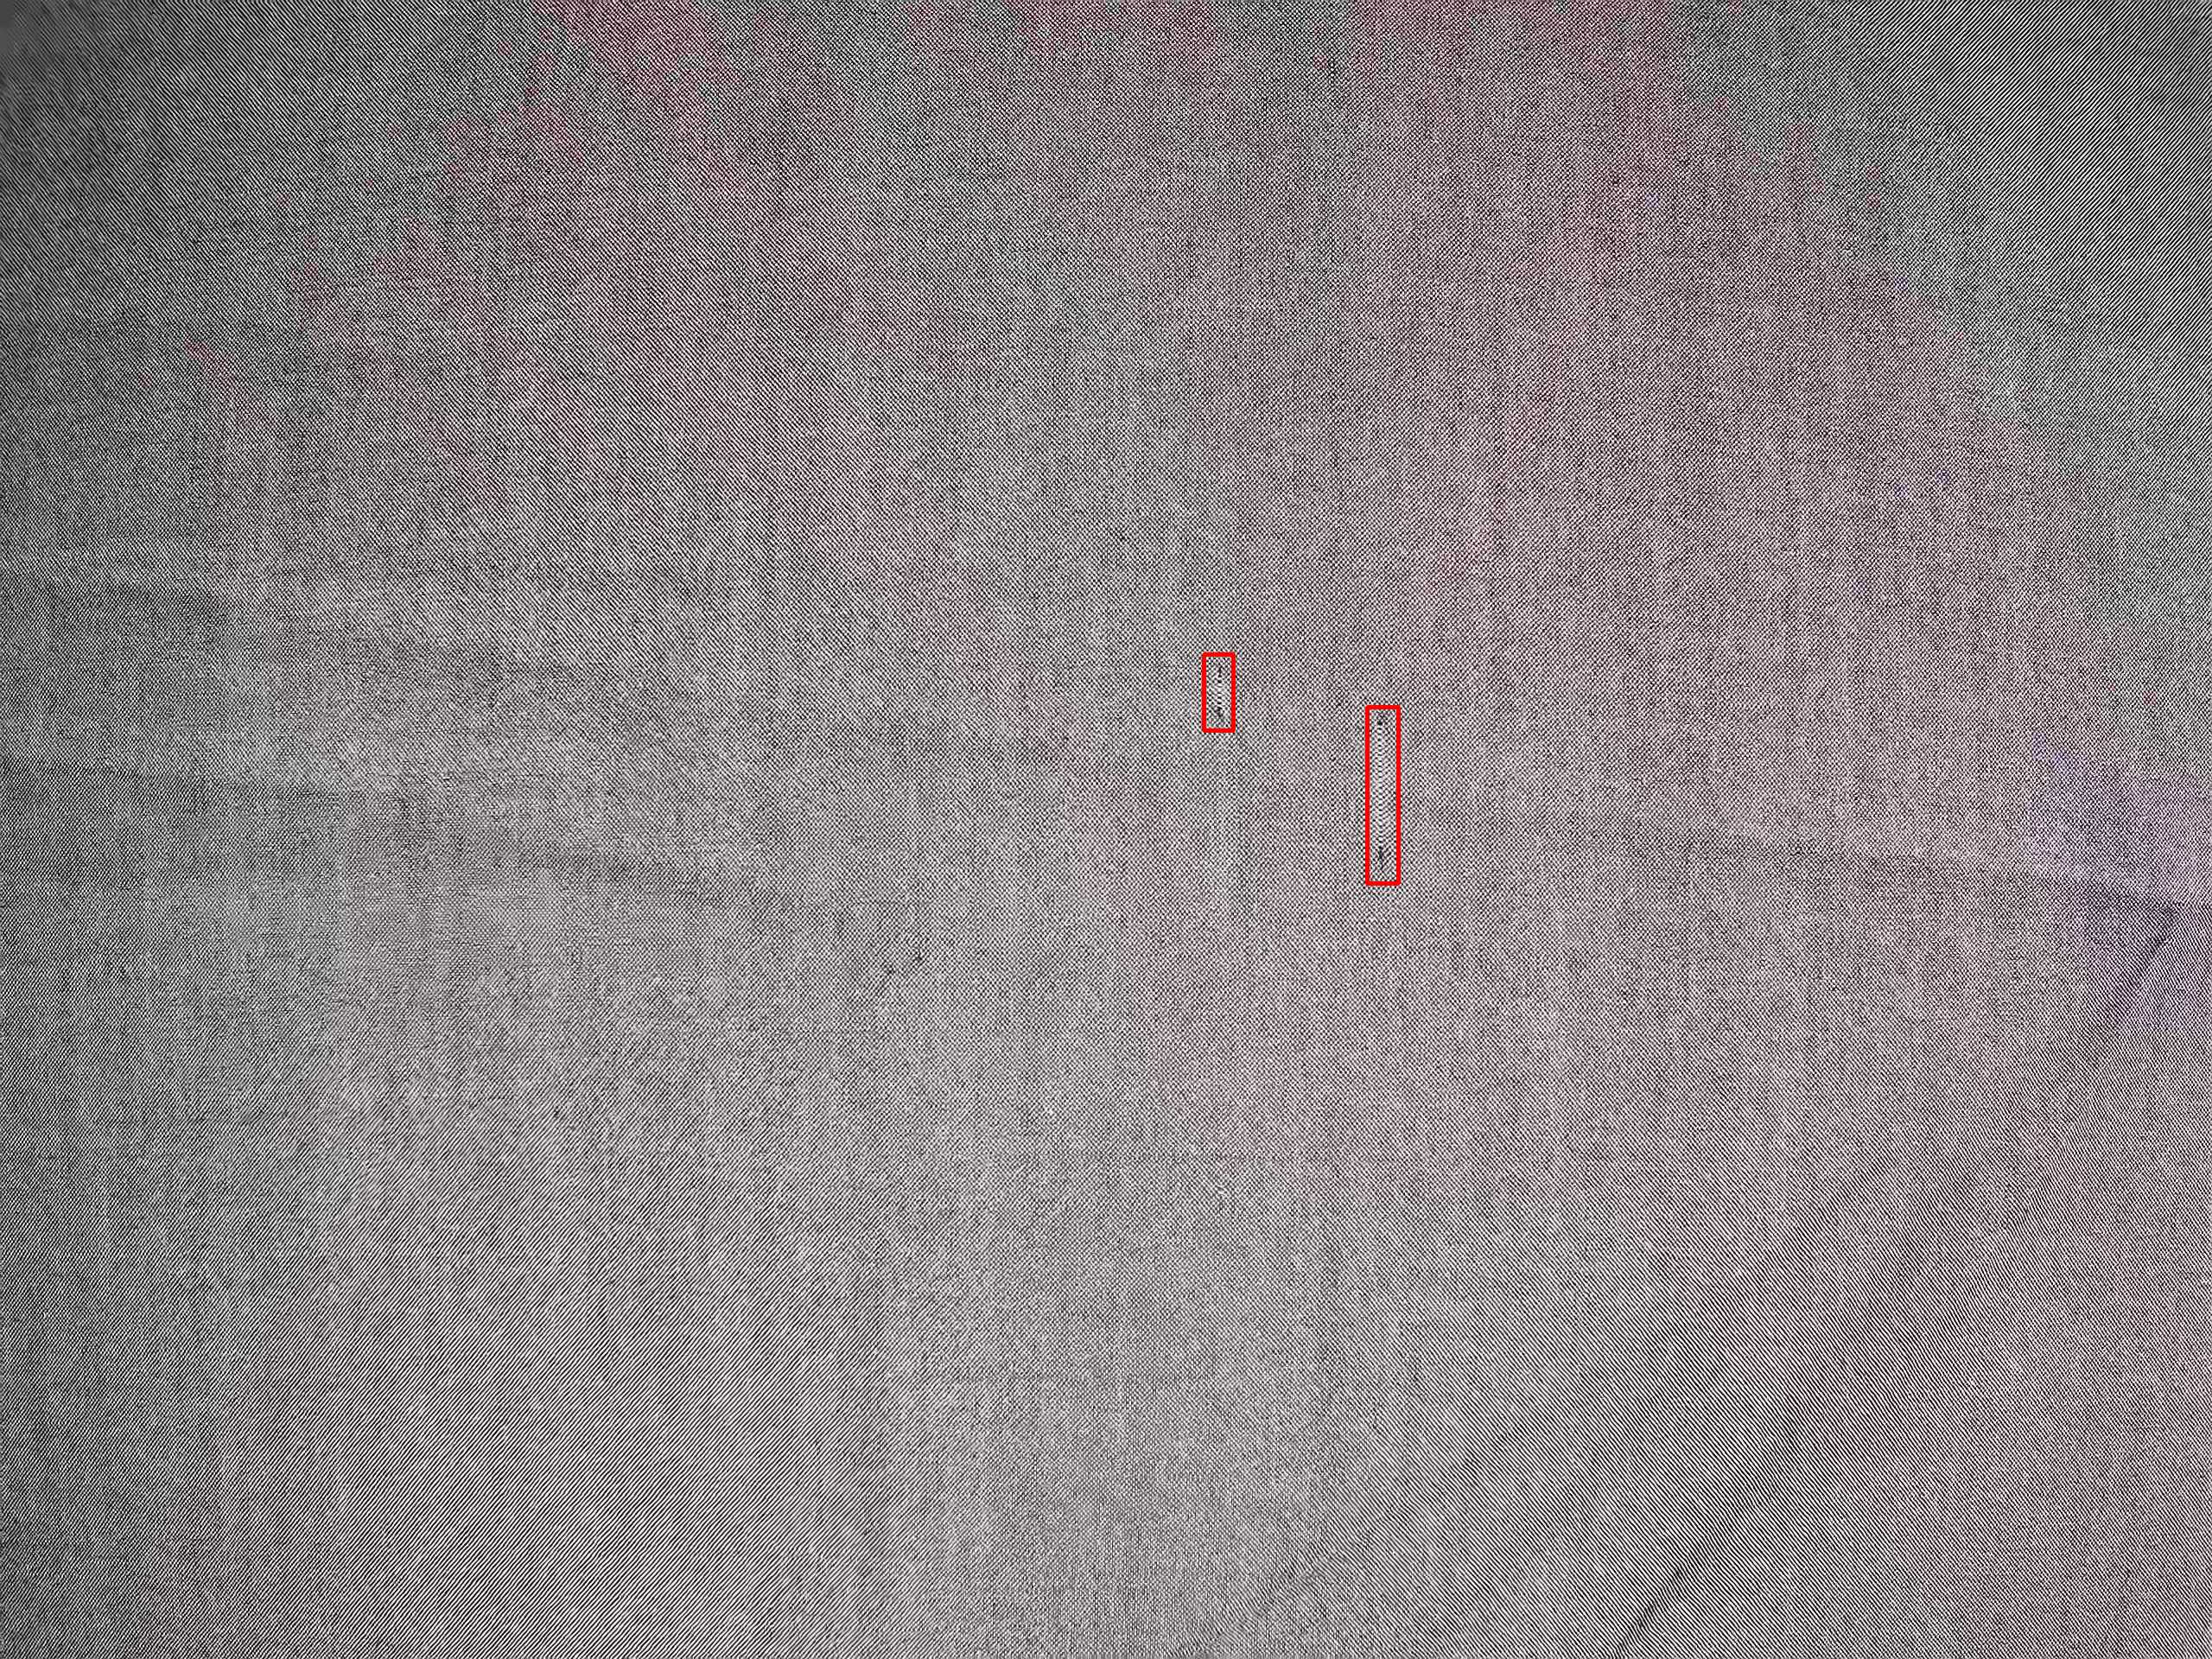

In [14]:
img = cv2.imread(img_fname)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_vis = img.copy()
xml_fname = img_fname.replace('.jpg', '.xml')
tree = ET.parse(xml_fname)
bboxs = []
for ob in tree.findall('object'):
    bbox = ob.find('bndbox')
    tagname = ob.find('name').text
    bbox = [int(x.text) for x in bbox.getchildren()]
    bboxs.append(bbox)
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=3)

show(img_vis)

n_x: 1, n_y: 1, 1450.5, 770.5
n_x: 1, n_y: 1, 1260.5, 651.5


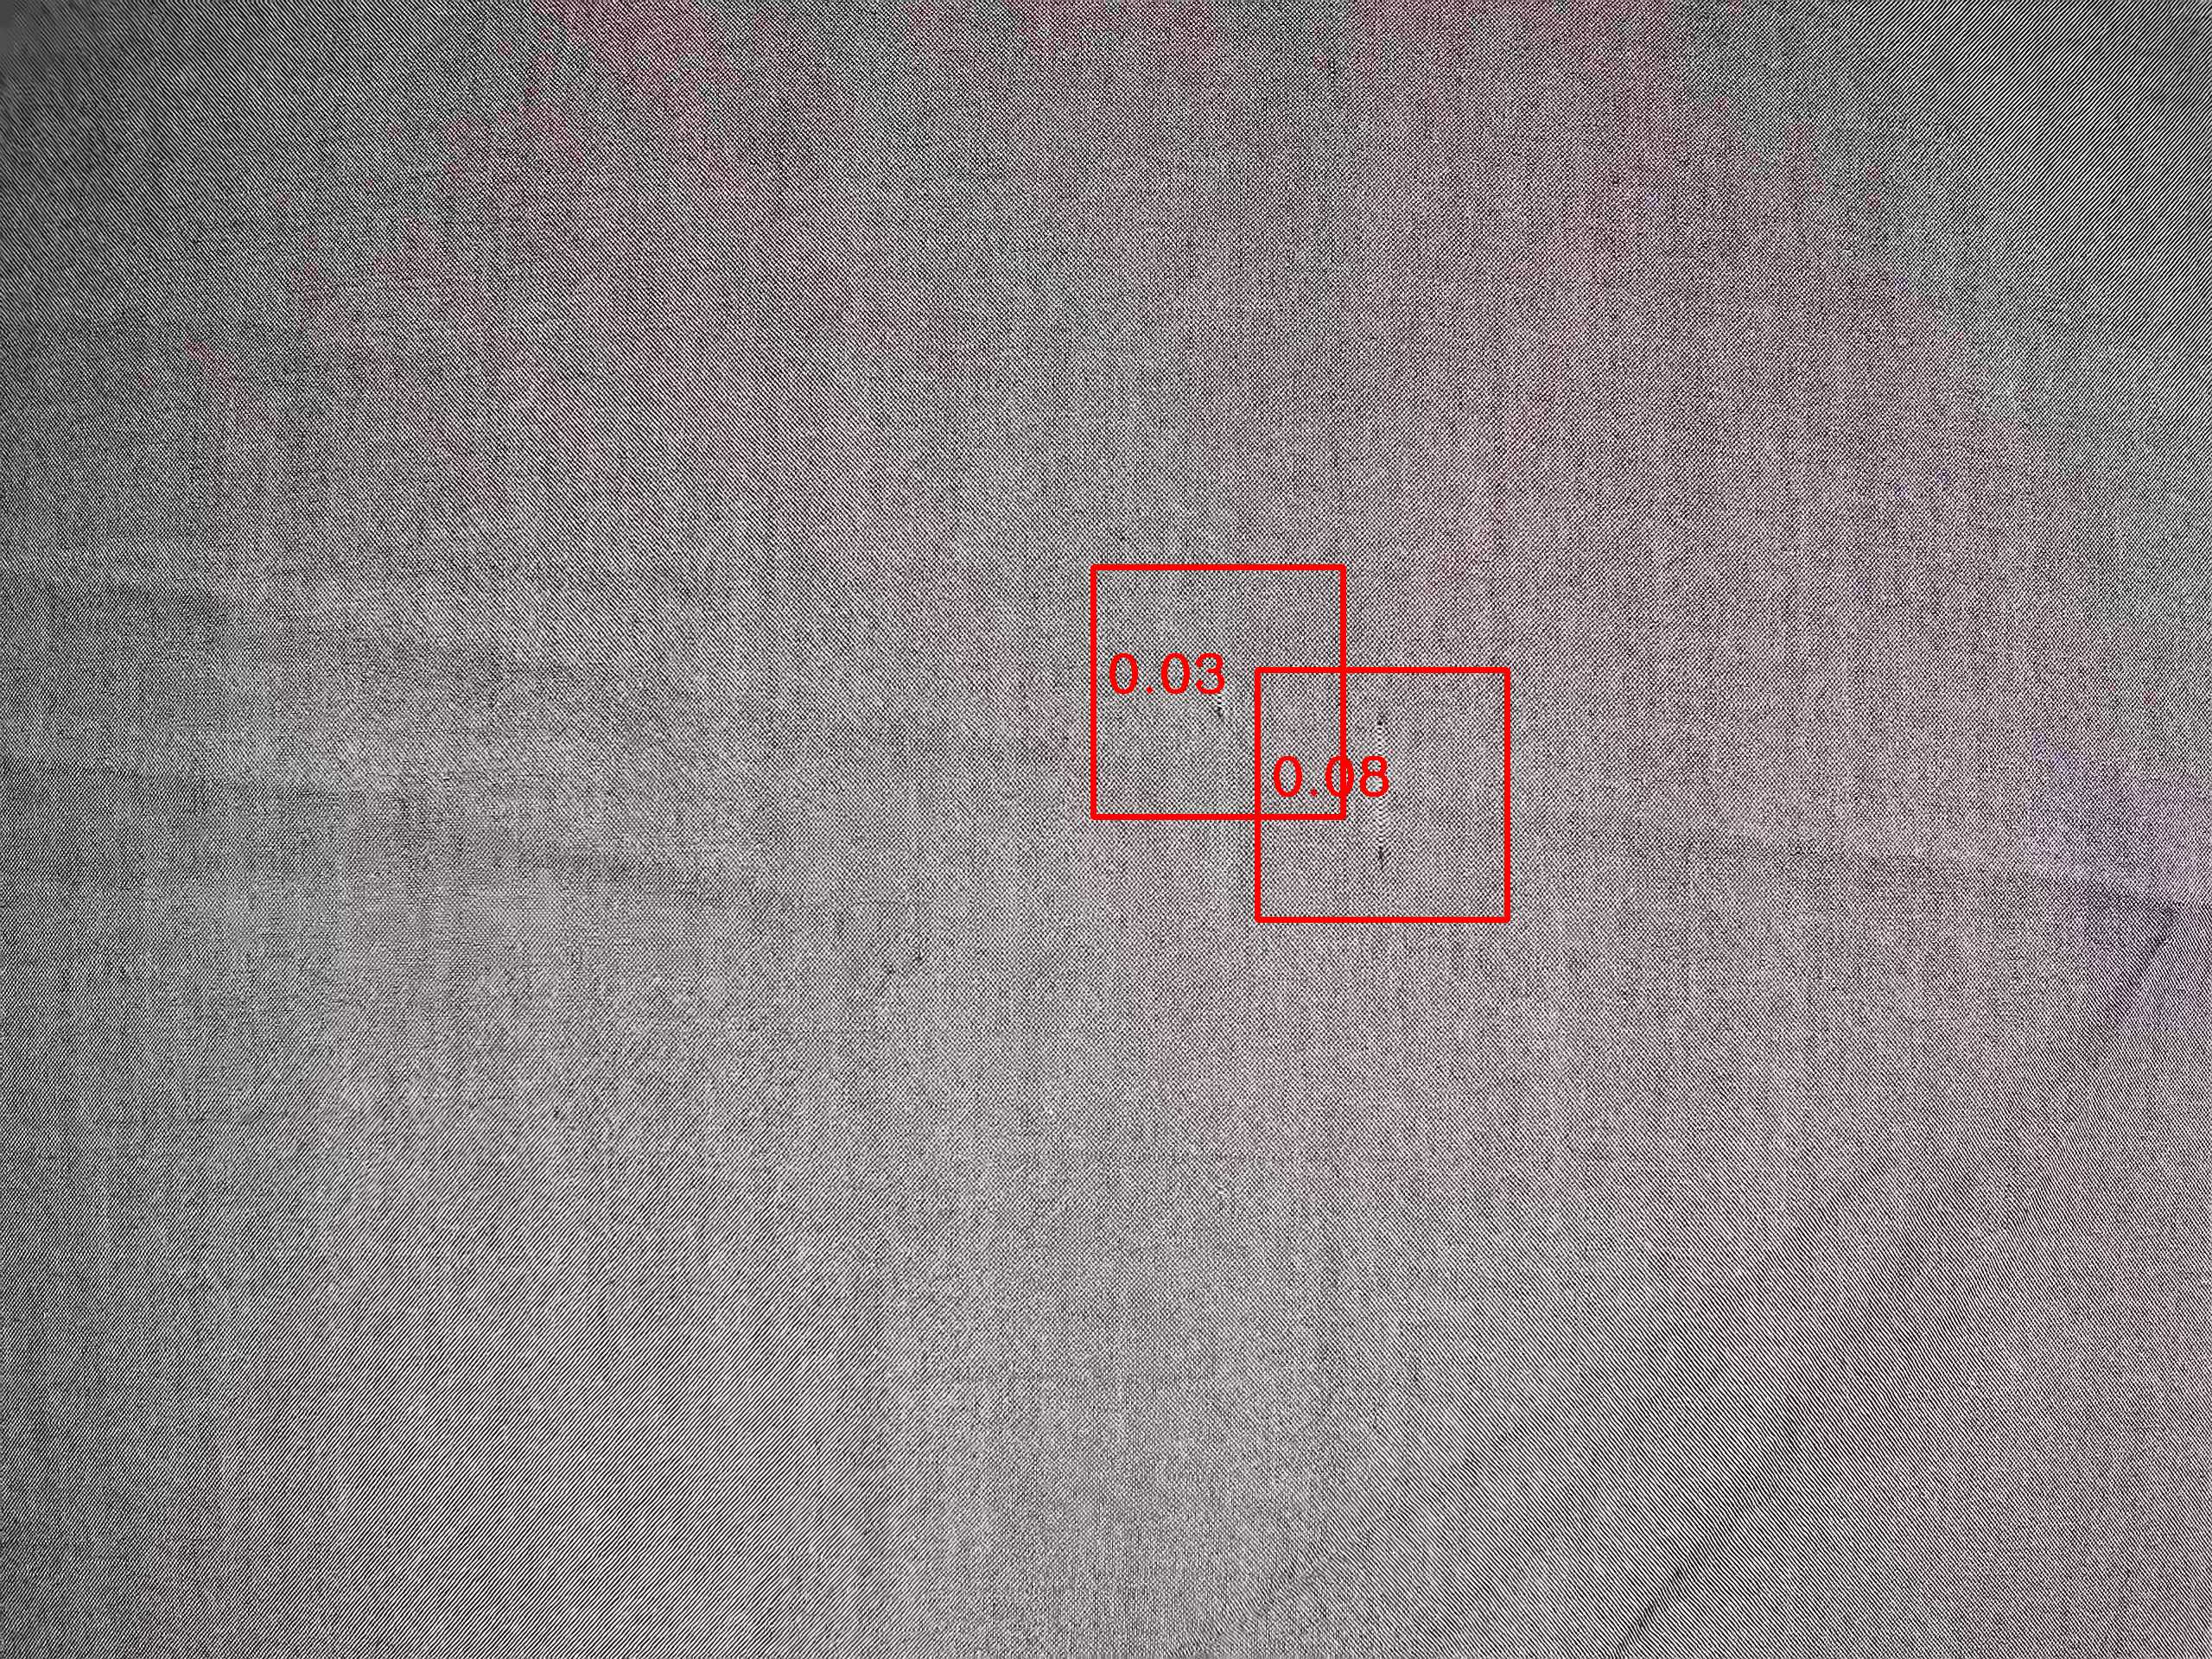

In [17]:
img_vis = img.copy()
for x12, y12, x22, y22 in bboxs:
    x_center = (x12 + x22) / 2
    y_center = (y12 + y22) / 2
    f_width = x22 - x12
    f_height = y22 - y12
    n_x = max(np.ceil(f_width / 2 / target_width - 0.5), 1)
    n_y = max(np.ceil(f_height / 2 / target_width - 0.5), 1)
    
    x_offset = x_center - target_width / 2
    y_offset = y_center - target_width / 2
    
    if f_width - target_width / 2 > target_width:
        x_offset -= n_x * target_width
        n_x = n_x * 2 + 1
    
    if f_height - target_width / 2 > target_width:
        y_offset -= n_y * target_width
        n_y = n_y * 2 + 1
    
    print(f'n_x: {n_x}, n_y: {n_y}, {x_offset}, {y_offset}')
    
    for i in range(int(n_x)):
        for j in range(int(n_y)):
            x1 = int(i * target_width + x_offset)
            y1 = int(j * target_width + y_offset)
            x2 = int((i + 1) * target_width + x_offset)
            y2 = int((j + 1) * target_width + y_offset)
            
            if x1 < 0:
                x1 = 0
                x2 = target_width
            
            if x2 > width:
                x1 = width - target_width
                x2 = width
            
            if y1 < 0:
                y1 = 0
                y2 = target_width
            
            if y2 > height:
                y1 = height - target_width
                y2 = height

            d = 5
            union, value = check_union(x1, y1, x2, y2, bboxs)
            if union:
                cv2.rectangle(img_vis, (x1+d, y1+d), (x2-d, y2-d), color=(0, 0, 255), thickness=d)
                cv2.putText(img_vis, f'{value:.2f}', (x1+20, y2-150), cv2.FONT_HERSHEY_COMPLEX, 2, (0,0,255), 3)
            else:
                cv2.rectangle(img_vis, (x1+d, y1+d), (x2-d, y2-d), color=(0, 255, 0), thickness=d)

show(img_vis)

In [ ]:
img_vis = img.copy()
for i in range(int(np.ceil(width / target_width))):
    for j in range(int(np.ceil(height / target_width))):
        x1 = i * target_width
        y1 = j * target_width
        x2 = (i + 1) * target_width
        y2 = (j + 1) * target_width
        
        if x2 > width:
            x1 = width - target_width
            x2 = width
        
        if y2 > height:
            y1 = height - target_width
            y2 = height
        
        d = 5
        union, value = check_union(x1, y1, x2, y2, bboxs)
        if union:
            cv2.rectangle(img_vis, (x1+d, y1+d), (x2-d, y2-d), color=(0, 0, 255), thickness=d)
            cv2.putText(img_vis, f'{value:.2f}', (x1+20, y2-150), cv2.FONT_HERSHEY_COMPLEX, 2, (0,0,255), 3)
        else:
            cv2.rectangle(img_vis, (x1+d, y1+d), (x2-d, y2-d), color=(0, 255, 0), thickness=d)

show(img_vis)